# Extraction-based MRC

## 1. Extraction-based MRC

* Extraction-based MRC의 정의
  * 질문(question)의 답변(answer)이 항상 주어진 지문(context)내에 span으로 존재
  * e.g. SQuAD, KorQuAD, NewsQA, Natural Questions, etc.
  * text의 위치만 파악하는 것으로 문제를 fomulate 하기 때문에 편리함

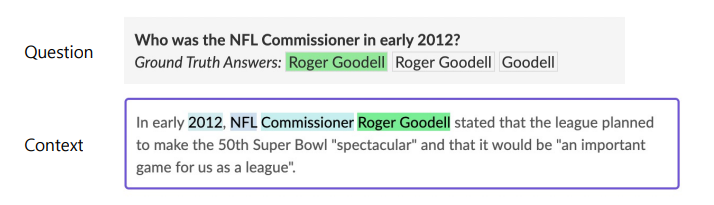

* Extraction-based MRC 문제 정의
  * Extraction-based MRC datasets in Hugging Face datasets (https://hugingface.co/datasets)
    * 다루기 쉬운 일반적인 format으로 구성되어 있음

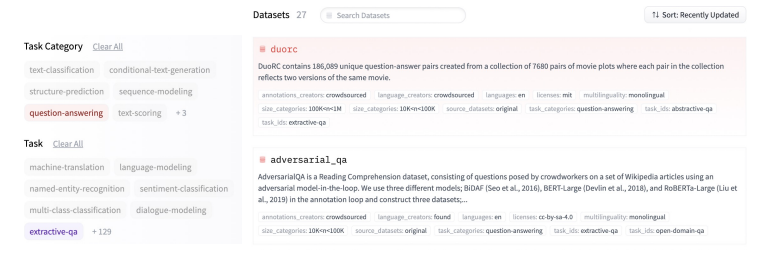

* Extraction-based MRC 평가 방법

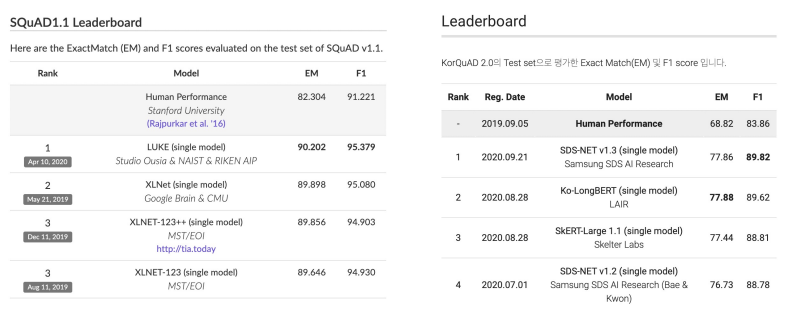

* Extraction-based MRC 평가 방법
  * Exact Match (EM) Score
    * 예측값과 정답이 character 단위로 완전히 똑같을 경우에만 1점 부여
    * 하나라도 다른 경우 0점

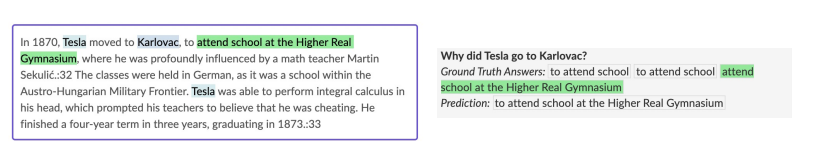

* Extraction-based MRC 평가 방법
  * F1 Score
    * 예측값과 정답의 overlap을 비율로 계산
    * 0점과 1점 사이의 부분점수를 받을 수 있음
    * Precision
      * num(same_tokens) : 예측값과 정답값의 일치하는 token 총 개수
      * num(pred_tokens) : 예측값의 token 총 개수
        * 예측값이 커질경우 precision 값이 작아짐
    * Recall
      * num(same_tokens) : 예측값과 정답값의 일치하는 token 총 개수
      * num(ground_tokens) : 실제 정답값의 token 총 개수
    * ground-truth이 하나가 아닌 경우 ground-answer에 대해 각각 계산하여 실제 evaluation은 그 중 가장 높은 숫자를 내보냄

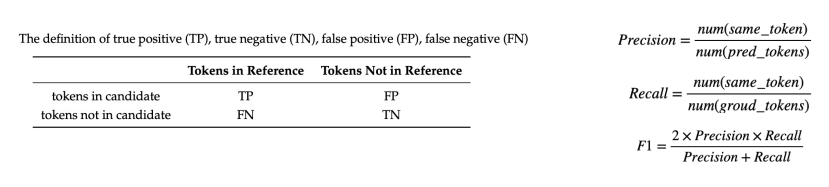

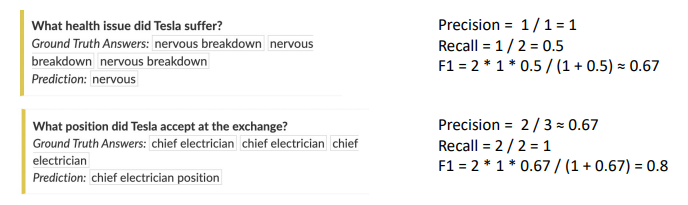

* Extraction-based MRC Overview
  * tokenization을 활용하여 input이 쪼개져서 들어감
  * mold embedding을 활용하여 벡터화 시켜 모델에 들어감
  * 모델의 output : 시작점, 끝점
    * context와 question에 해당하는 contextualized vector들을 각각 scalar value로 내보냄 : 각 시작 또는 끝값이 될 수 있는 점수
    * 이 점수중에 가장 높은 위치를 찾아 start position과 end position을 예측함
  * start position과 end position 사이에 있는 span을 최종 값으로 내보냄

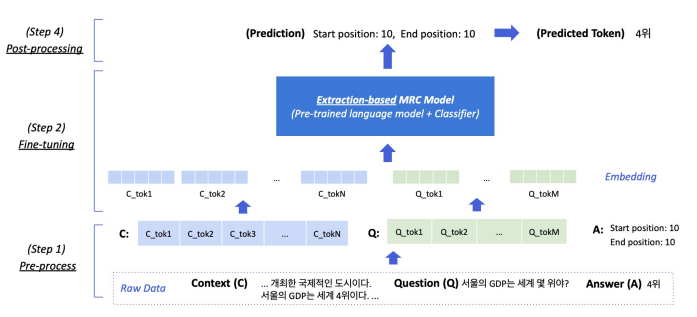

## 2. Pre-processing

* 입력 예시
  * title, context, question-answer pair가 주어짐

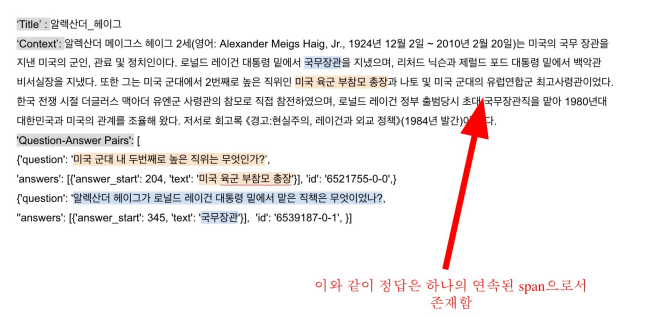

* Tokenization
  * 텍스트를 작은 단위(Token)로 나누는 것
    * 띄어쓰기 기준, 형태소, subword 등 여러 단위 토큰 기준이 사용됨
    * 최근엔 Out-Of-Vocabulary (OOV) 문제를 해결해주고 정보학적으로 이점을 가진 Byte Pair Encoding (BPE) 을 주로 사용함
    * 본강에선 BPE 방법론중 하나인 WordPiece Tokenizer를 사용

    WordPiece Tokenizer 예시
      "미국 군대 내 두번째로 높은 직위는 무엇인가?"
      ['미국', '군대', '내', '두번째', '##로', '높은', '직', '##위는', '무엇인가', '?']
      <br>: 자주 나오는 단어는 하나로 합쳐져있고(미국, 군대) 자주 나오지 않는 단어는 나뉨(직, ##위는)

* Special Tokens
  * special token을 활용하여 question과 context를 구분함

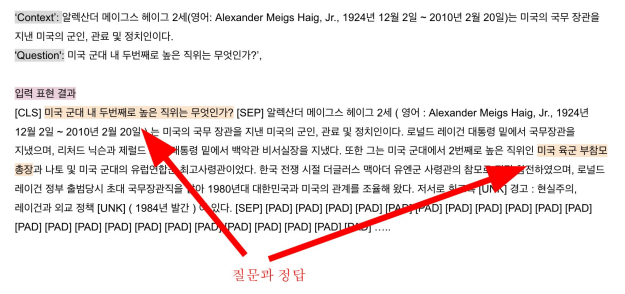

* Special Tokens
  * tokenize 이후에도 남아있음

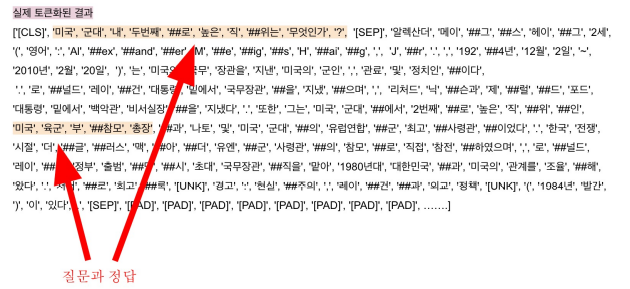

* Attention Mask
  * 입력 시퀀스 중에서 attention을 연산할 때 무시할 토큰을 표시
  * 0은 무시, 1은 연산에 포함
  * 보통 [PAD]와 같은 의미가 없는 특수 토큰을 무시하기 위해 사용

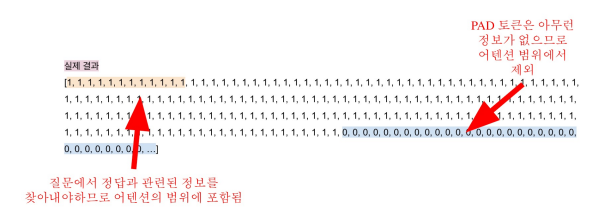

* Token Type IDs
  * 입력이 2개 이상의 시퀀스일 때 (예: 질문 & 지문), 각각에게 ID를 부여하여 모델이 구분해서 해석하도록 유도
    * flag를 0과 1로 주어 구분함
    * 질문 : 0, context : 1, pad : 0

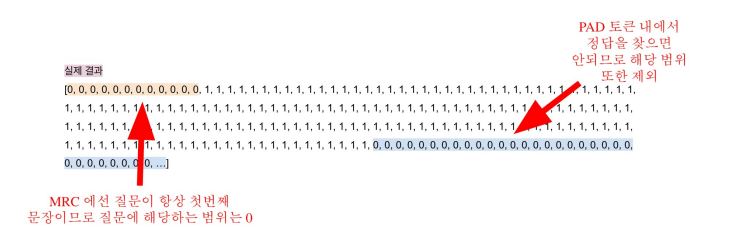

* 모델 출력값
  * 학습할 때는 정답도 같이 줘야함
    * context에서 answer의 위치를 주지만 tokenize 후에는 token의 위치를 파악해야하기 때문에 약간의 processing이 필요함
    * 단어가 세부적으로 나뉘게 되면 정답이 정확하지 않기 때문에, 최소한으로 포함하는 단어들을 정답으로 포함하여 학습에 사용함
  * 정답은 문서내 존재하는 연속된 단어토큰 (span)이므로, span의 시작과 끝 위치를 알면 정답을 맞출 수 있음
  * Extraction-based에선 답안을 생성하기 보다, 시작위치와 끝위치를 예측하도록 학습함. 즉 Token Classification 문제로 치환함

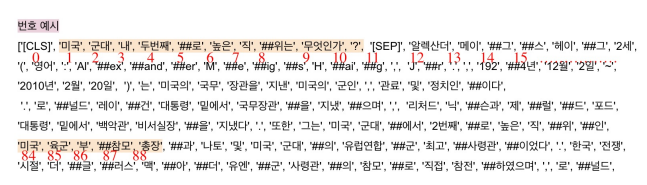

## 3. Fine-tuning

* Extraction-based MRC Overview
  * 이 강의에서 BERT를 magic box라고 생각하고 자세하게 다루지 않을 예정
  * BERT
    * input : context, question 의 token embedding
    * output : context, question 의 token embedding
      * contextualized 되어 있음
      * 활용도가 높음
      * prediction을 낼 수 있도록 점수화 시켜야 함

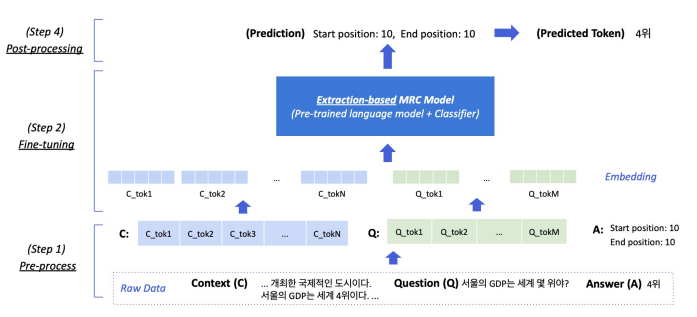

* Fine-tuning BERT
  * prediction을 낼 수 있도록 점수화 하는 가장 간단한 방법
    * 지문 내에서 정답에 해당하는 각 embedding을 linear transformation(이것도 학습 대상)을 통해서 하나의 숫자(점수)가 나올 수 있도록 바꿔줌
      * 숫자가 높을수록 정답으로 볼 수 있음
    * 이 방식으로 start position과 end position을 구해서 최종 답안을 구함
    * 실제 학습할 때는 수치를 softmax 위에 apply하고 negative log likelihood로 학습하는 방식을 취함

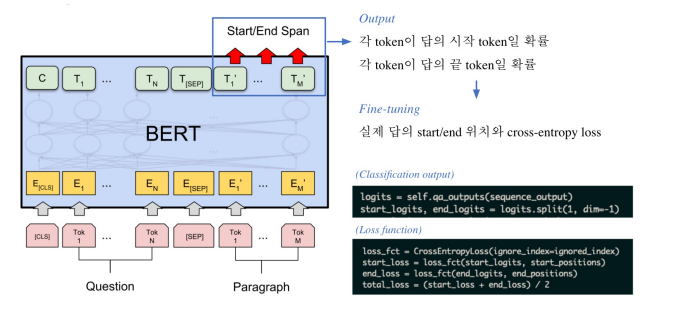

## 4. Post-processing

* 불가능한 답 제거하기
  * 다음과 같은 경우 candidate list에서 제거
    * End position 이 start position보다 앞에 있는 경우 (e.g. start = 90, end = 80)
    * 예측한 위치가 context를 벗어난 경우 (e.g. question 위치쪽에 답이 나온 경우)
    * 미리 설정한 max_answer_length 보다 길이가 더 긴 경우

* 최적의 답안 찾기
  1. Start / end position prediction에서 score (logits) 가 가장 높은 N개를 각각 찾음
  2. 불가능한 start/end 조합을 제거함
  3. 가능한 조합들을 score의 합이 큰 순서대로 정렬함
  4. Score가 가장 큰 조합을 최종 예측으로 선정함
  5. Tok-k 가 필요한 경우 차례대로 내보냄